In [ ]:
pip install transformers

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/INFO555/Project2/v3/annotation_data.csv'
df = pd.read_csv(file_path)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import pipeline
import numpy as np

# initialize zero-shot classification pipeline
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# candidate labels with more detailed neutral descriptions
sentiment_labels = [
    'Positive',
    'Negative',
    'Neutral, factual, or objective',  # expanded neutral definition. to help the zero-shot classifier better recognize neutral content by providing more context about what "neutral" means
]

# classification function with enhanced neutral detection
def classify_sentiment_improved(row):
    sentence = row['Sentence']

    result = zero_shot_classifier(
        sentence,
        candidate_labels=sentiment_labels,
        hypothesis_template="This text is {}."
    )

    # scores and labels
    scores = result['scores']
    predicted_label = result['labels'][0]
    max_score = max(scores)

    # if the difference between top scores is small, likely neutral
    score_difference = max_score - sorted(scores)[-2]

    # check for neutral characteristics
    factual_check = zero_shot_classifier(
        sentence,
        candidate_labels=['subjective opinion', 'objective fact'],
        hypothesis_template="This text is {}."
    )

    # conditions for neutral classification:
    # 1. small difference between positive/negative scores (uncertain classification)
    # 2. high objective fact score
    if (score_difference < 0.1 or
        (factual_check['labels'][0] == 'objective fact' and
         factual_check['scores'][0] > 0.7)):
        return 'Neutral', max_score

    return predicted_label.split(',')[0], max_score

# improved classification
def process_dataset(df):
    df_sentiment = df[df['Category'] == 'Sentiment'].copy()
    train_df, test_df = train_test_split(df_sentiment, test_size=0.2, random_state=42)

    for dataset in [train_df, test_df]:
        dataset['Predicted_Sentiment'], dataset['Sentiment_Score'] = zip(
            *dataset.apply(classify_sentiment_improved, axis=1)
        )

    return train_df, test_df

def evaluate_results(train_df, test_df):
    for name, df in [('Training', train_df), ('Testing', test_df)]:
        accuracy = accuracy_score(df['Annotation1'], df['Predicted_Sentiment'])
        report = classification_report(df['Annotation1'], df['Predicted_Sentiment'])
        confusion = confusion_matrix(df['Annotation1'], df['Predicted_Sentiment'])

        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Classification Report:\n{report}")
        print(f"Confusion Matrix:\n{confusion}")

        # sample predictions
        if name == 'Testing':
            print("\nSample Predictions:")
            print(df[['Sentence', 'Annotation1', 'Predicted_Sentiment', 'Sentiment_Score']].head())

# main execution
train_df, test_df = process_dataset(df)
evaluate_results(train_df, test_df)


Training Results:
Accuracy: 0.807
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.95      0.93        39
     Neutral       0.00      0.00      0.00         8
    Positive       0.81      0.83      0.82        41

    accuracy                           0.81        88
   macro avg       0.57      0.59      0.58        88
weighted avg       0.78      0.81      0.79        88

Confusion Matrix:
[[37  2  0]
 [ 0  0  8]
 [ 4  3 34]]

Testing Results:
Accuracy: 0.682
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      1.00      0.88         7
     Neutral       0.50      0.33      0.40         6
    Positive       0.67      0.67      0.67         9

    accuracy                           0.68        22
   macro avg       0.65      0.67      0.65        22
weighted avg       0.66      0.68      0.66        22

Confusion Matrix:
[[7 0 0]
 [1 2 3]
 [1 2 6]]

Sample Predictions:
 

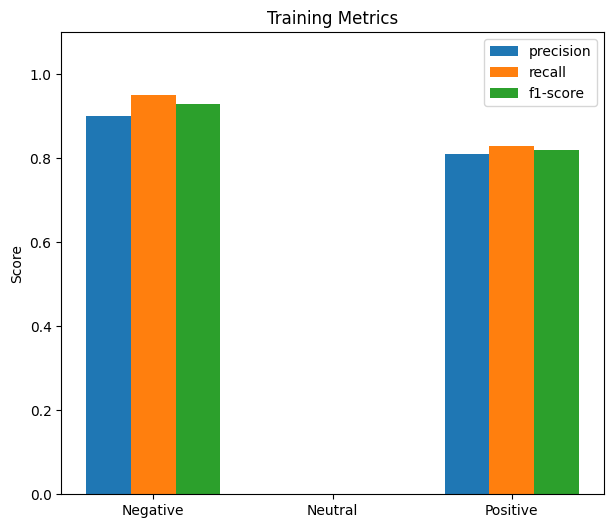

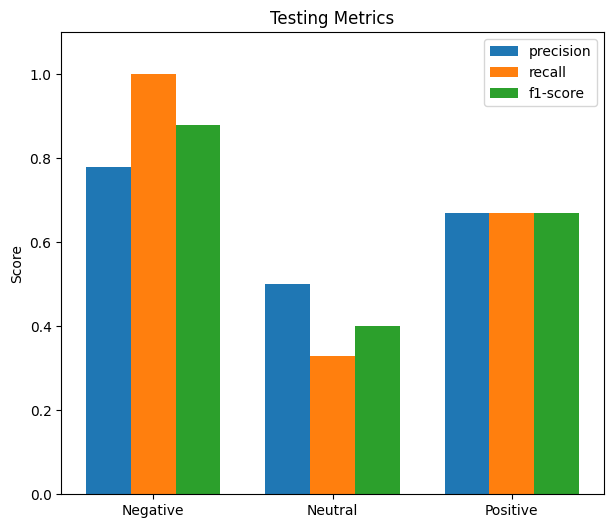

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_metrics = {
    "Negative": {"precision": 0.90, "recall": 0.95, "f1-score": 0.93},
    "Neutral": {"precision": 0.00, "recall": 0.00, "f1-score": 0.00},
    "Positive": {"precision": 0.81, "recall": 0.83, "f1-score": 0.82},
}

test_metrics = {
    "Negative": {"precision": 0.78, "recall": 1.00, "f1-score": 0.88},
    "Neutral": {"precision": 0.50, "recall": 0.33, "f1-score": 0.40},
    "Positive": {"precision": 0.67, "recall": 0.67, "f1-score": 0.67},
}

categories = ["Negative", "Neutral", "Positive"]
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(categories))
width = 0.25

plt.figure(figsize=(7, 6))
for i, metric in enumerate(metrics):
    plt.bar(
        x + (i - 1) * width,
        [train_metrics[cat][metric] for cat in categories],
        width,
        label=metric,
    )

plt.title("Training Metrics")
plt.xticks(x, categories)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.legend()
plt.show()

plt.figure(figsize=(7, 6))
for i, metric in enumerate(metrics):
    plt.bar(
        x + (i - 1) * width,
        [test_metrics[cat][metric] for cat in categories],
        width,
        label=metric,
    )

plt.title("Testing Metrics")
plt.xticks(x, categories)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.legend()
plt.show()